In [3]:
import torch
from tqdm.notebook import tqdm
import torchvision.models as models
import torch.nn.functional as F
import os
from data.DataLoader import ImageNetDataset, load_data
import cv2
import torchvision.transforms as transforms
from attack import fgsm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from utils import Avg_Metric
from PIL import Image
import lovely_tensors as lt
import copy
lt.monkey_patch()
%matplotlib inline

PROJ_DIR = os.path.join(os.getcwd(), 'data')
IMAGENET_PATH = os.path.join(PROJ_DIR, 'ImageNet')
DAMAGE_PATH = os.path.join(PROJ_DIR, 'DAmageNet')
TRAIN_IMG_DIR = os.path.join(IMAGENET_PATH, 'train')
VAL_IMG_DIR = os.path.join(IMAGENET_PATH, 'val')
TEST_IMG_DIR = os.path.join(IMAGENET_PATH, 'train')
DAMAGE_IMG_DIR = os.path.join(DAMAGE_PATH, 'test')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
transform = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
    ])

img = Image.open('./original.png').convert('RGB')
img = transform(img)
random = torch.randn(img.shape)
print(img.shape)
print(img)
batch = torch.stack([img, random], dim=0)
print(batch.shape)
mean, std = batch.mean([2,3]), batch.std([2,3])
print(mean.shape)
print(std.shape)
batch = (batch - mean[:, :, None, None]) / std[:, :, None, None]
print(batch[0])
print(batch[1])

torch.Size([3, 299, 299])
tensor[3, 299, 299] n=268203 x∈[0.098, 1.000] μ=0.924 σ=0.205
torch.Size([2, 3, 299, 299])
torch.Size([2, 3])
torch.Size([2, 3])
tensor[3, 299, 299] n=268203 x∈[-6.556, 0.404] μ=2.685e-08 σ=1.000
tensor[3, 299, 299] n=268203 x∈[-4.461, 4.493] μ=1.024e-09 σ=1.000


In [2]:
with open('imagenet_classes.txt', 'r') as f:
    imagenet_classes = f.readlines()
    imagenet_classes_short = [x.strip().split(',')[-1]
                              for x in imagenet_classes]

In [3]:
def plot_top_classes(values, top_k=5):
    sorted_classes = np.argsort(-values)
    class_ids = sorted_classes[:top_k]
    class_names = [imagenet_classes_short[it] for it in list(class_ids)]
    class_values = values[class_ids]
    plt.bar(class_names, class_values)
    plt.xticks(rotation=60)
    return class_names[0]

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def prepare_image(image_cv2, do_normalize=True):
    # Resize
    img = cv2.resize(image_cv2, (224, 224))
    img = img[:, :, ::-1].copy()
    # Convert to tensor
    tensor_img = transforms.functional.to_tensor(img)

    # Possibly normalize
    if do_normalize:
        tensor_img = normalize(tensor_img)
    # Put image in a batch
    batch_tensor_img = torch.unsqueeze(tensor_img, 0).to(device)

    return batch_tensor_img


def UnNormalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]):
    std_arr = torch.tensor(std)[:, None, None]
    mean_arr = torch.tensor(mean)[:, None, None]

    def func(img):
        img = img.clone()
        img *= std_arr
        img += mean_arr
        return img
    return func


unnormalize = UnNormalize()


def obtain_image(tensor_img, do_normalize=True):
    tensor_img = tensor_img.cpu()
    if do_normalize:
        tensor_img = unnormalize(tensor_img)
    img = transforms.functional.to_pil_image((tensor_img.data))
    return img

In [5]:
dataset = ImageNetDataset(TEST_IMG_DIR, os.path.join(IMAGENET_PATH, 'test.txt'), None)
print(len(dataset))
img, label, attack = dataset[1]
print(imagenet_classes_short[label])
print(img.shape)

5000
hamster
torch.Size([3, 224, 224])


In [4]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT).to(device)
adv = copy.deepcopy(model)
model.eval()
loss = nn.CrossEntropyLoss()
starting_img = prepare_image(img, do_normalize=False)
input_img = starting_img.clone().requires_grad_(True)

NameError: name 'prepare_image' is not defined

'hamster'

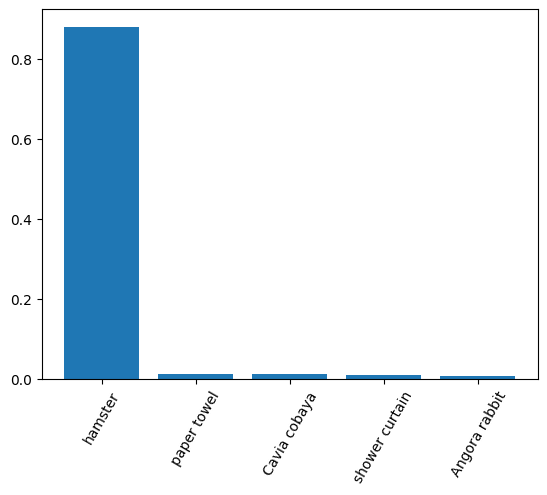

In [ ]:
output = model(input_img)
prob = F.softmax(output, dim=1)
plot_top_classes(prob[0,:].data.cpu().numpy())

In [ ]:
attacked_res = fgsm(input_img, torch.tensor([label]), model, loss, epsilon=0.3)
original_img = obtain_image(starting_img[0, :], do_normalize=False)
attacked_img = obtain_image(attacked_res[0, :], do_normalize=False)

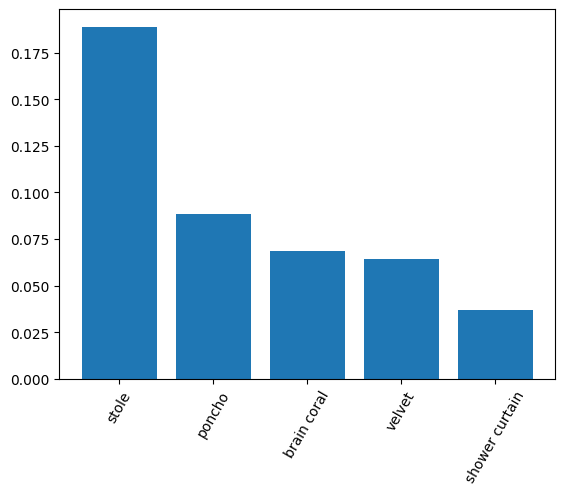

In [ ]:
output = model(attacked_res)
prob = F.softmax(output, dim=1)
pred = plot_top_classes(prob[0,:].data.cpu().numpy())

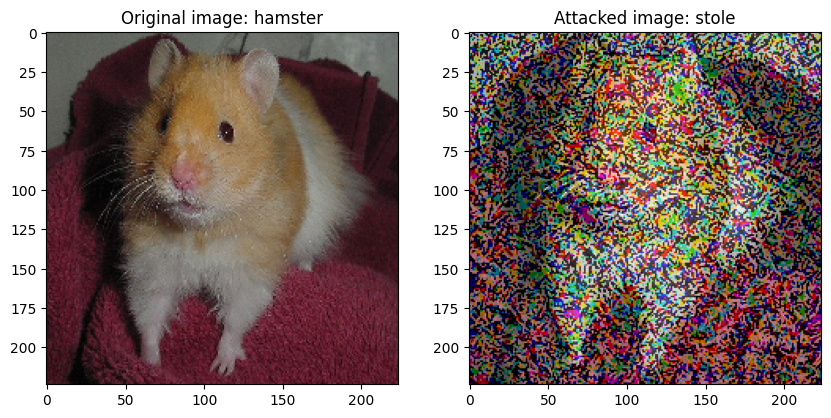

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original image: ' + imagenet_classes_short[label] + '')
axs[0].imshow(original_img)
axs[1].set_title('Attacked image: ' + pred + '')
axs[1].imshow(attacked_img)

# Generate all attacks

In [3]:
classifiers = [{'model': models.resnet34(weights=models.ResNet34_Weights.DEFAULT).to(device).eval(), 'name': 'resnet34'},
               {'model':  models.resnet50(
                   weights=models.ResNet50_Weights.DEFAULT).to(device).eval(), 'name': 'resnet50'},
               {'model':  models.resnet101(
                   weights=models.ResNet101_Weights.DEFAULT).to(device).eval(), 'name': 'resnet101'}]
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
loss = nn.CrossEntropyLoss()
BATCH_SIZE = 32

origin_loader = load_data('val', batch_size=BATCH_SIZE, apply_trans=True)
data_loader = load_data('test', batch_size=BATCH_SIZE, apply_trans=False)
for classifier in classifiers:
    no_attack = Avg_Metric()
    model = classifier['model']
    with torch.no_grad():
        for i, (data, labels, attacked_data) in enumerate(tqdm(origin_loader)):
            data = data.to(device)
            labels = labels.to(device)
            logits = model(data)
            pred = torch.argmax(logits, dim=1)
            no_attack.update(torch.sum(pred == labels).item(), BATCH_SIZE)
    print('Classifier: {}, Original accuracy: {:.2f}%'.format(
        classifier['name'], no_attack.avg * 100))
    for epsilon in epsilons:
        attack = Avg_Metric()
        for i, (data, labels, attack_data) in enumerate(tqdm(data_loader)):
            data = data.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                logits = model(data)
            pred = torch.argmax(logits, dim=1)
            idx = (pred == labels).nonzero(as_tuple=True)[0]
            data = data[idx]
            labels = labels[idx]
            input_img = data.clone().requires_grad_(True)
            attacked_res = fgsm(input_img, labels,
                                model, loss, epsilon=epsilon)
            logits = model(attacked_res)
            probs = F.softmax(logits, dim=1)
            _, pred = torch.max(probs, dim=1)
            attack.update(torch.sum(pred == labels).item(), BATCH_SIZE)
        print('Epsilon: {}, Attack accuracy: {:.2f}%'.format(
            epsilon, attack.avg * 100))

Loading data from /data/vision/polina/projects/wmh/inr-atlas/zeenchi/code/matrix/data/ImageNet/val.txt
Length of val set is: 5000
Loading data from /data/vision/polina/projects/wmh/inr-atlas/zeenchi/code/matrix/data/ImageNet/test.txt
Length of test set is: 5000


  0%|          | 0/157 [00:00<?, ?it/s]

Classifier: resnet34, Original accuracy: 56.27%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.05, Attack accuracy: 0.50%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.1, Attack accuracy: 0.62%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.15, Attack accuracy: 0.46%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.2, Attack accuracy: 0.26%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.25, Attack accuracy: 0.22%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.3, Attack accuracy: 0.12%


  0%|          | 0/157 [00:00<?, ?it/s]

Classifier: resnet50, Original accuracy: 79.14%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.05, Attack accuracy: 32.50%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.1, Attack accuracy: 26.83%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.15, Attack accuracy: 17.70%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.2, Attack accuracy: 10.11%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.25, Attack accuracy: 5.61%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.3, Attack accuracy: 2.95%


  0%|          | 0/157 [00:00<?, ?it/s]

Classifier: resnet101, Original accuracy: 80.61%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.05, Attack accuracy: 36.62%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.1, Attack accuracy: 31.53%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.15, Attack accuracy: 23.93%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.2, Attack accuracy: 16.62%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.25, Attack accuracy: 10.87%


  0%|          | 0/157 [00:00<?, ?it/s]

Epsilon: 0.3, Attack accuracy: 5.97%
